In [1]:
import numpy as np
from scipy.linalg import expm, ishermitian
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import SwapGate, RYGate, QFT
from copy import deepcopy
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import pylatexenc

In [5]:
# Number of Qubits needed to hold eigenvalues
eig_num = 4
# Define a parameter n_time for a parameter of the Hamiltonian Simulation Time
n_time = 1
# Number of Qubits needed to hold right side vector
b_num = int(np.log2(len(b_herm)))
# Hamiltonian Parameter --> Defines the total time for the Hamiltonial simulations
t_ = (1 - 2**(-1*eig_num))*n_time*np.pi/4
print(t_)
# Rotation parameter --> From paper on Quantum Circuit Design choose value between 5 and 6 for best results. We select 5 (for higher success rate)
rot = 5
# New implementation via arcsin function to get theta values
# Total number of circuit runs
shots = 80000

0.7363107781851077


In [6]:
def construct_quantum_circuit(r,t_,A_herm,b_herm):
    #=========================== Quantum Circuit ========================================#
    # Qubits
    anc = QuantumRegister(1,'anc')
    a_reg = QuantumRegister(eig_num, 'Eig_Reg')
    b_reg = QuantumRegister(b_num, 'b_reg')
    # Classical Bits
    cbit_anc = ClassicalRegister(1,'ancilla_cbit')
    cbit_b = ClassicalRegister(b_num, 'regB')
    # Initialize circuit
    circuit = QuantumCircuit(anc,a_reg,b_reg,cbit_anc,cbit_b)
    # Initialize state b
    init = Initialize(list(b_herm))
    circuit.append(init,b_reg)
    circuit.draw()
    # Apply H-gate on quantum register a
    circuit.h(a_reg)
    # Apply controlled Hamiltonian operators on quantum register b
    for i in range(eig_num):
        sim_time = t_/(2**(eig_num-i))
        U = HamiltonianGate(A_herm, sim_time)
        G = U.control(1)
        qubit = [i+1]+[eig_num+j+1 for j in range(b_num)]
        circuit.append(G,qubit)
    
    # Apply inverse Quantum Fourier Transform
    iqft = QFT(eig_num, approximation_degree=0, do_swaps=True, inverse=True, name='IQFT')
    circuit.append(iqft, a_reg)
    # Swap Qubits in quantum register A
    G = SwapGate()
    circuit.append(G,[a_reg[1],a_reg[eig_num-1]])
    
    #=================================Conditioned Rotation of Ancilla==============================#
    # Apply Y Rotations in quantum register A
    
    ## Applying conditional rotation based Hamiltonian simulation time --> Does not work too well!
    #for i in range(eig_num):
    #    theta = 2*np.pi*i/t
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
    
    # Applying conditional rotation based on the number of qubits in the eigenvalue register --> Works with scaling factor at output
    #for i in range(eig_num):
    #    theta = np.pi/(2**(eig_num - i))
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
    
    ## Applying the decimal representation of the clock qubits --> Works with scaling factor at output
    for i in range(eig_num):
        theta = 2*math.asin(1/(2**i))
        U = RYGate(theta).control(1)
        circuit.append(U,[i+1,0])
    
    # Uses the eigenvalues and condition number to compute the angle for rotation --> Requires computation of eigenvalues via classical means
    #eigs = np.linalg.eigvals(A_herm)
    #cond = 5/np.linalg.cond(A_herm)
    #for i in range(eig_num):
    #    lambda_j = (2**eig_num)*t*eigs[i]/(2*np.pi)
    #    theta = math.acos(cond/lambda_j)
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
        
    # Uses the rotation parameter r from paper on Quantum Circuit Design --> Works best for r=5
    #for i in range(eig_num):
    #    theta = (2**(eig_num - r -i))*np.pi
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
    #
    
    #=============================== Uncompute the Circuit =========================#
    # Swap qubits in quantum register A
    G = SwapGate()
    circuit.append(G,[a_reg[1], a_reg[eig_num-1]])
    # Apply Quantum Fourier Transform
    qft = QFT(eig_num, approximation_degree=0, do_swaps=True, inverse=False, name='QFT')
    circuit.append(qft, a_reg)
    # Apply inverse controlled Hamiltonian Operators
    for i in range(eig_num-1, -1, -1):
        time = t_/(2**(eig_num-i))
        U = HamiltonianGate(-A_herm, time)
        G = U.control(1)
        qubit = [i+1]+[eig_num+j+1 for j in range(b_num)]
        circuit.append(G,qubit)
    # Apply H Gate on Quantum Register A
    circuit.h(a_reg)
    # Measure the qubits
    circuit.measure(anc, cbit_anc)
    circuit.measure(b_reg, cbit_b)
    # Return constructed circuit
    return circuit

In [18]:
def iterative_hhl(A_herm,b_herm,iteration):
    r0 = b_herm
    xm = np.zeros(len(b_herm))
    rm = r0
    x = np.zeros(len(b_herm))
    xm = np.zeros(len(b_herm))
    for i in range(iteration):
        beta = np.linalg.norm(rm,2)
        r_old = rm
        rm = rm/beta
        A_herm = A_herm/beta
        quantum_circuit = construct_quantum_circuit(rot,t_,A_herm,rm)
        sim = Aer.get_backend("aer_simulator_statevector")
        job = execute(quantum_circuit,backend=sim,shots=shots)
        results = job.result().get_counts()
        y = np.zeros(len(b_herm))
        for key in results:
            results[key] *= (1/shots)
        for key in results:
            if key[-1] == '1':
                pos = int(key[0:2],2)
                y[pos] = results[key]
        #shift = 0.1*abs(y)
        #shift =
        if i == 0:
            shift = 0 * y
        else:
            shift = np.sqrt(np.linalg.norm(y,2)/np.linalg.norm(y_old,2)) * abs(y)
        if i > 0:
            xm = y - old_shift
        else:
            xm = y
        x = x + xm
        x = abs(x)
        rm = b_herm - np.dot(A_herm,x-shift)
        print(x, np.linalg.norm(rm,2))
        if np.linalg.norm(rm,2)/np.linalg.norm(r0,2) < 1e-5:
            break
        y_old = y
        old_shift = shift
    return x,A_herm,rm,quantum_circuit

In [19]:
A_herm = np.loadtxt('a_herm.txt')
b_herm = np.loadtxt('b_herm.txt')

In [20]:
beta = np.linalg.norm(b_herm,2)
b_herm = b_herm/beta
A_herm = A_herm/beta
#b_herm = -1*b_herm/beta
print(beta)

1.0


In [21]:
A_herm

array([[ 623.79809835, -499.03847868,  124.75961967,    0.        ],
       [-499.03847868,  748.55771802, -499.03847868,    0.        ],
       [ 124.75961967, -499.03847868,  623.79809835,    0.        ],
       [   0.        ,    0.        ,    0.        ,  124.75961967]])

In [26]:
true = np.linalg.solve(A_herm,b_herm)
print(true)
error = []
it = []
x,A,r,qc_final = iterative_hhl(A_herm,b_herm,20)

[0.01156925 0.01619695 0.01156925 0.        ]
[0.1969   0.235    0.196125 0.      ] 46.30145375569219
[0.3147875 0.4533625 0.3102    0.       ] 0.8764283144942782
[0.2748026  0.40906412 0.26898025 0.        ] 0.6652769570251407
[0.26574428 0.42958437 0.25229129 0.        ] 0.5223405139492764
[0.24018435 0.40107084 0.23019698 0.        ] 0.4339663088657261
[0.35510672 0.53153315 0.25868331 0.        ] 10.316103511834568
[0.20609475 0.43232454 0.42545635 0.        ] 1.2167185127547324
[0.20732393 0.33223715 0.28537502 0.        ] 1.0118559286777264
[0.18812525 0.30127385 0.27811483 0.        ] 0.9661975308112752
[0.18342368 0.29975531 0.29506722 0.        ] 0.9703841040657135
[0.18193499 0.31072659 0.30890773 0.        ] 0.9814005148414382
[0.18308342 0.31179011 0.30808194 0.        ] 0.9888396991287048
[0.183378   0.31308564 0.30361064 0.        ] 0.9926348315447405
[0.18359253 0.31562086 0.30779375 0.        ] 0.9974872453904957
[0.18487558 0.31770155 0.30538551 0.        ] 0.999891993

In [27]:
normx = np.linalg.norm(x,2)
print(normx)
xstar = x/normx

0.4770198219886829


0.008775526189874507
[-0.         -0.00340886 -0.00584892 -0.00558387 -0.        ]


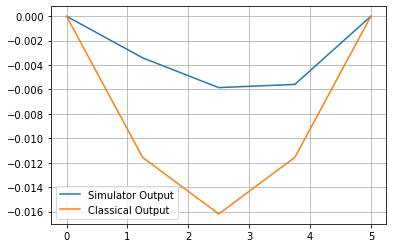

In [28]:
f = np.linalg.norm(r,2)/np.linalg.norm(np.dot(A_herm,xstar),2)
print(f)
ax = np.linspace(0,5,5)
sol = np.array([0, xstar[0],xstar[1],xstar[2],xstar[3]])
plt.plot(ax, -f*abs(sol), label='Simulator Output')
true = np.linalg.solve(A_herm,b_herm)
analytical = np.asarray([0, true[0],true[1],true[2],true[3]])
plt.plot(ax, -1*analytical, label='Classical Output')
plt.legend()
plt.grid()
print(-f*sol)

In [114]:
analytical

array([0.        , 0.01156925, 0.01619695, 0.01156925, 0.        ])

In [25]:
err = abs(f*sol/np.linalg.norm(sol,2) - analytical)
print(f'L2 Error Norm: {np.linalg.norm(err,2)}\nRelative Error: {round(np.linalg.norm(err,2)*100/np.linalg.norm(analytical,2),3)} %')

L2 Error Norm: 0.0019137326079574205
Relative Error: 8.312 %


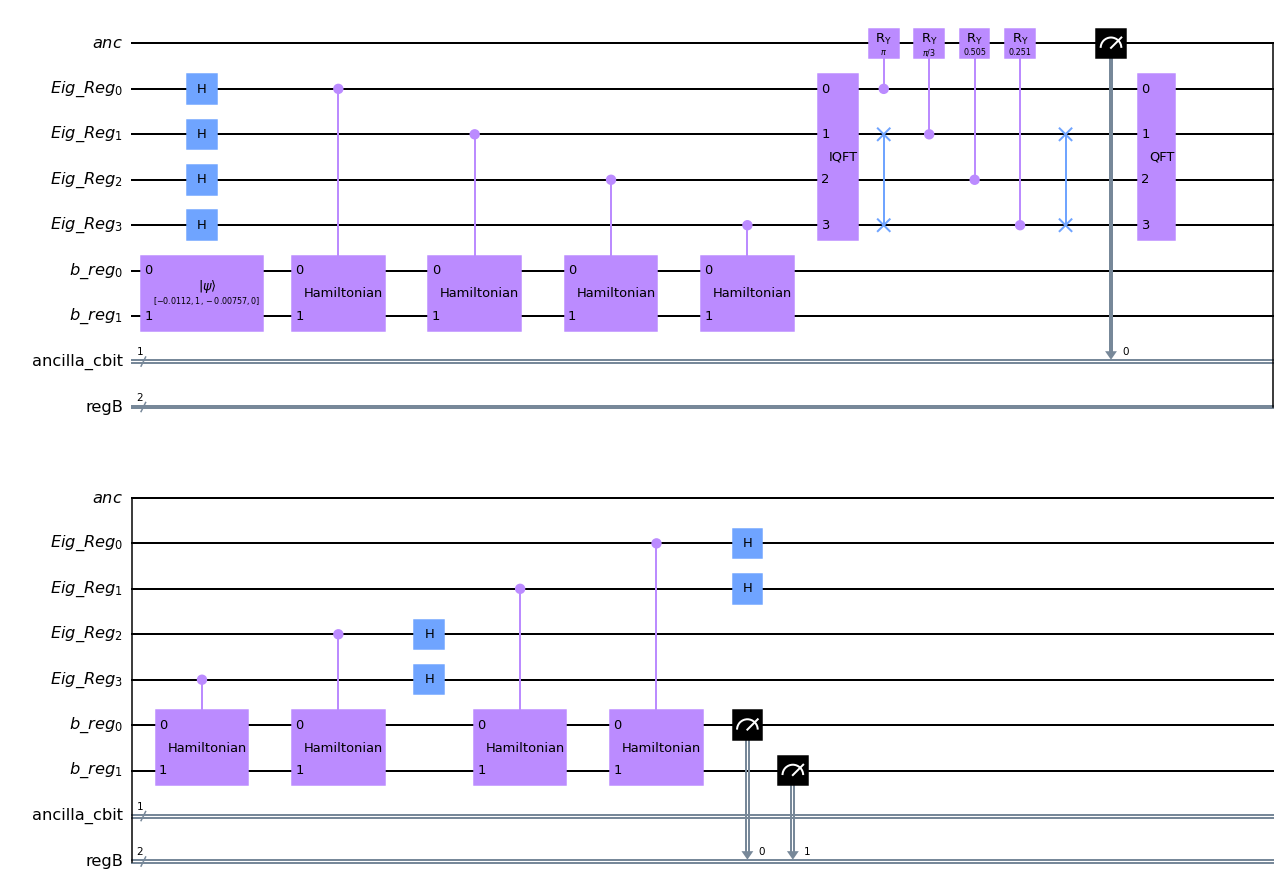

In [224]:
qc_final.draw('mpl')

In [227]:
qc_final = transpile(qc_final, basis_gates=['u', 'cx'])
print(f'Circuit Depth: {qc_final.depth()}\nCircuit Width: {qc_final.width()}')

Circuit Depth: 568
Circuit Width: 10


In [ ]:
anc = QuantumRegister(1,'anc')
a_reg = QuantumRegister(eig_num, 'Eig_Reg')
b_reg = QuantumRegister(b_num, 'b_reg')
    # Classical Bits
cbit_anc = ClassicalRegister(1,'ancilla_cbit')
cbit_b = ClassicalRegister(b_num, 'regB')
    # Initialize circuit
circuit = QuantumCircuit(anc,a_reg,b_reg,cbit_anc,cbit_b)
    # Initialize state b
init = Initialize(list(b_herm))
circuit.append(init,b_reg)
    circuit.draw()
    # Apply H-gate on quantum register a
    circuit.h(a_reg)
    # Apply controlled Hamiltonian operators on quantum register b
    for i in range(eig_num):
        sim_time = t_/(2**(eig_num-i))
        U = HamiltonianGate(A_herm, sim_time)
        G = U.control(1)
        qubit = [i+1]+[eig_num+j+1 for j in range(b_num)]
        circuit.append(G,qubit)